# Example: StudyForest

In [1]:
# for auto-reloading external modules
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [19]:
import numpy as np
import pandas as pd
import scipy as sp

import networkx as nx
import bct

import dyneusr as ds

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set("paper", "white")

%matplotlib inline

## Load data

In [4]:
from load_data import load_studyforest, Bunch

# load data
data = load_studyforest(n_subjects=1, n_runs=-1)

# set index of meta
data.meta = data.meta.set_index(['subject_id','run_id','TR','start','stop'])

# show quick description
print()
print(data.data.shape, data.meta.shape)
print(data.X.shape, data.y.shape)
print(data.keys())

INFO:load_data:load_studyforest(n_subjects=1, n_runs=-1)
INFO:load_data:Loading data...


(3599, 30) (3599, 275)

(3599, 278) (3599, 28)
(3599, 278) (3599, 33)
dict_keys(['data', 'meta', 'encoders', 'masker', 'atlas', 'X', 'y'])


/Users/calebgeniesse/src/miniconda3/lib/python3.6/site-packages/nilearn/signal.py:60: RuntimeWarning: invalid value encountered in less
  std[std < np.finfo(np.float).eps] = 1.  # avoid numerical problems


### Visual inspection of data, meta

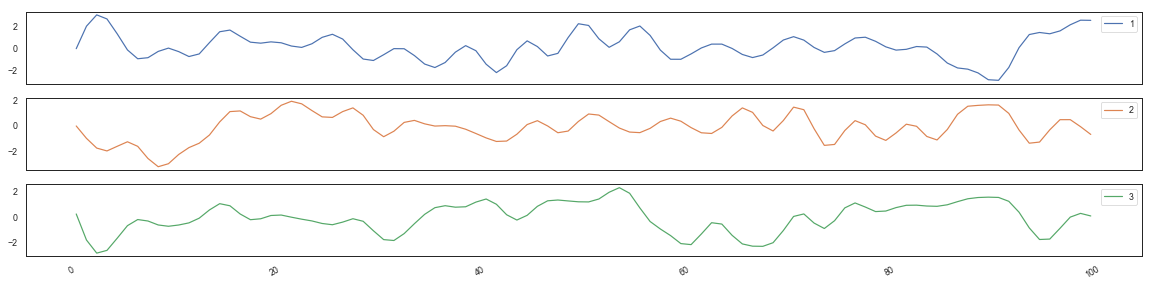

In [5]:
data.data.iloc[:100,:3].plot(figsize=(20,5), subplots=True)
plt.show()

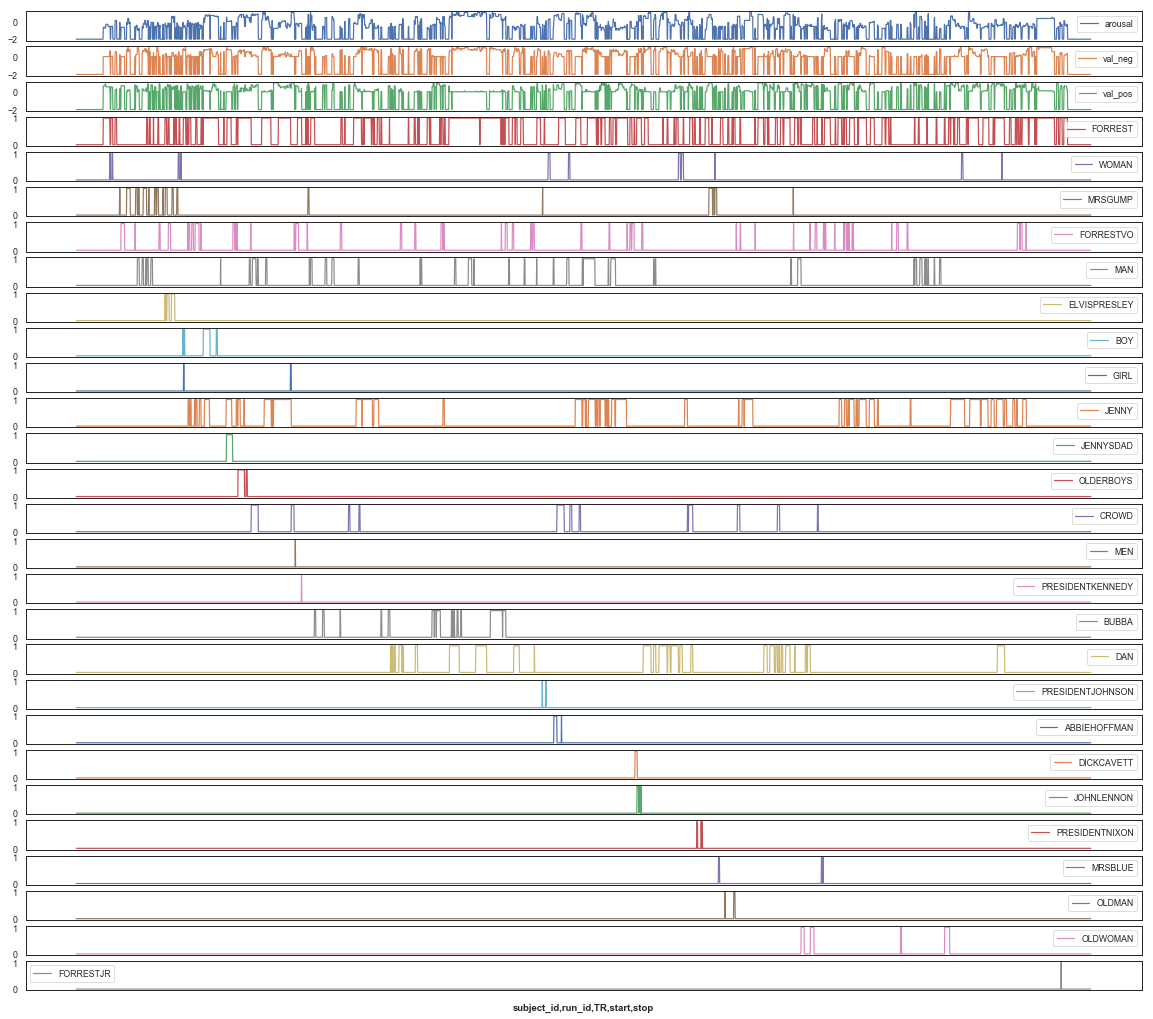

In [6]:
data.meta.plot(figsize=(20,20), subplots=True)
plt.show()

## Generate $MAPPER$ graph

In [7]:
# define inputs: X=data, y=meta
X = data.data.values
X_inverse = data.data.values

# define y col
y_col = 'arousal'
#y_col = 'val_pos'
#y_col = 'val_neg'
y = data.meta[y_col].values
y[y==-2.0] = np.nan

# define y labels (optional)
labels = data.encoders[0][y_col].__dict__.get('classes_')
print('labels:', labels)


labels: None


In [8]:
import kmapper as km
from sklearn.manifold import TSNE

# init MAPPER
mapper = km.KeplerMapper(verbose=1)

# init MAPPER params
projection = TSNE(perplexity=50, init='pca', random_state=0)
clusterer = km.cluster.KMeans(2)
coverer = km.Cover(10, 0.5)

KeplerMapper()


In [9]:
# run MAPPER
lens = mapper.fit_transform(X, projection=projection)
graph = mapper.map(lens, X=X_inverse, clusterer=clusterer, coverer=coverer)

..Composing projection pipeline of length 1:
	Projections: TSNE(angle=0.5, early_exaggeration=12.0, init='pca', learning_rate=200.0,
   method='barnes_hut', metric='euclidean', min_grad_norm=1e-07,
   n_components=2, n_iter=1000, n_iter_without_progress=300, perplexity=50,
   random_state=0, verbose=0)
	Distance matrices: False
	Scalers: MinMaxScaler(copy=True, feature_range=(0, 1))
..Projecting on data shaped (3599, 278)

..Projecting data using: 
	TSNE(angle=0.5, early_exaggeration=12.0, init='pca', learning_rate=200.0,
   method='barnes_hut', metric='euclidean', min_grad_norm=1e-07,
   n_components=2, n_iter=1000, n_iter_without_progress=300, perplexity=50,
   random_state=0, verbose=1)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 3599 samples in 0.022s...
[t-SNE] Computed neighbors for 3599 samples in 5.813s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3599
[t-SNE] Computed conditional probabilities for sample 2000 / 3599
[t-SNE] Computed condition

### Visual inspection of lens

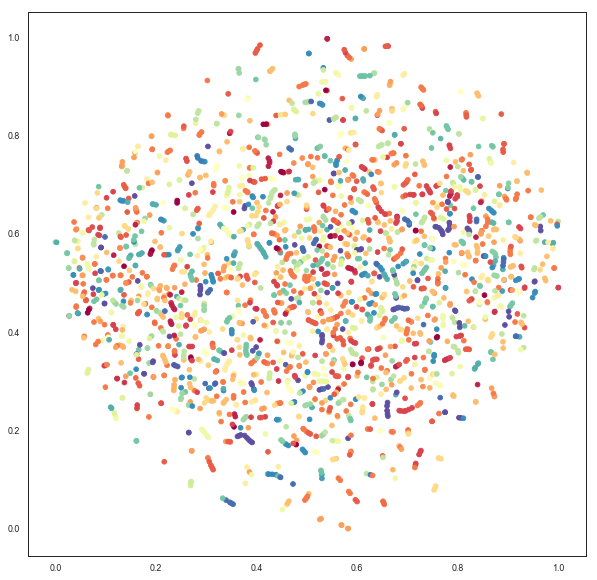

In [10]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
plt.scatter(*lens.T, c=y, cmap='Spectral')

## Fit a `DyNeuGraph` to the $MAPPER$ graph

In [20]:
# fit DyNeuGraph to MAPPER graph
dG = ds.DyNeuGraph()
dG.fit(graph, y=y, labels=labels)

# show shape of map_ (dimensions: nodes x members)
print()
print('dG.map_:', dG.map_.shape)
print('dG.G_.graph:', dG.G_.graph)

Found 4 unique groups.

dG.map_: (3599, 178)
dG.G_.graph: {'label': ['n/a', 'μ + -1σ', 'μ (= -0.06)', 'μ + 1σ'], 'groups': [0, 1, 2, 3]}


### Visual inspection of nx.Graph object

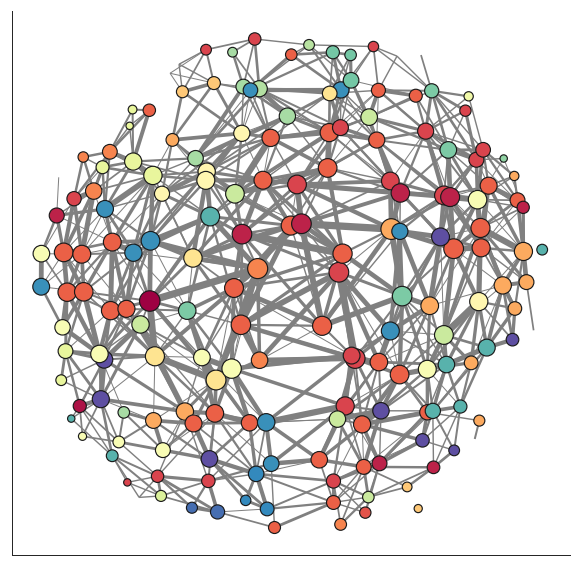

In [21]:
from collections import Counter
node_color = [Counter(y[dG.G_.nodes[n]['members']]).most_common()[0][0] for n in dG.G_]

# plot nx
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ds.tools.networkx_utils.draw_nx(
    dG.G_, lens=lens, pos="inverse", ax=ax, 
    node_color=node_color, cmap='Spectral',
    )

## Annotate Graph with images

### Generate Spatial Mixture Models (SMMs)

```
images = ds.tools.mixture.spatial_mixtures(X, mixtures=dG.mixtures_)
```

In [22]:
# use dG.G_.nodes to generate per-node SMMs
smm_images = ds.tools.mixture.spatial_mixtures(
       data, mixtures=dict(dG.G_.nodes("members")),
       prefix='node_', cut_coords=(8, -4, 9), 
       )

# annotate dG with images
dG.annotate(image=smm_images)

Building Mixture Model... ID: cube1_cluster0
Building Mixture Model... ID: cube1_cluster1
Building Mixture Model... ID: cube2_cluster1
Building Mixture Model... ID: cube2_cluster0
Building Mixture Model... ID: cube3_cluster1
Building Mixture Model... ID: cube3_cluster0
Building Mixture Model... ID: cube4_cluster0
Building Mixture Model... ID: cube4_cluster1
Building Mixture Model... ID: cube5_cluster1
Building Mixture Model... ID: cube5_cluster0
Building Mixture Model... ID: cube6_cluster1
Building Mixture Model... ID: cube6_cluster0
Building Mixture Model... ID: cube7_cluster1
Building Mixture Model... ID: cube7_cluster0
Building Mixture Model... ID: cube10_cluster0
Building Mixture Model... ID: cube10_cluster1
Building Mixture Model... ID: cube11_cluster0
Building Mixture Model... ID: cube11_cluster1
Building Mixture Model... ID: cube12_cluster0
Building Mixture Model... ID: cube12_cluster1
Building Mixture Model... ID: cube13_cluster1
Building Mixture Model... ID: cube13_cluster0
Bu

DyNeuGraph()

### Plot Temporal Connectivity Matrix (TCM)

```
images = ds.visuals.plot_temporal_matrix(dG.tcm_)
```

/Users/calebgeniesse/src/miniconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Saving figure, save_as: figures/tcm.png


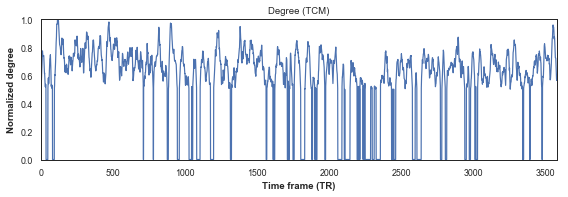

Annotating node... NodeID: cube1_cluster0
Annotating node... NodeID: cube1_cluster1
Annotating node... NodeID: cube2_cluster1
Annotating node... NodeID: cube2_cluster0
Annotating node... NodeID: cube3_cluster1
Annotating node... NodeID: cube3_cluster0
Annotating node... NodeID: cube4_cluster0
Annotating node... NodeID: cube4_cluster1
Annotating node... NodeID: cube5_cluster1
Annotating node... NodeID: cube5_cluster0
Annotating node... NodeID: cube6_cluster1
Annotating node... NodeID: cube6_cluster0
Annotating node... NodeID: cube7_cluster1
Annotating node... NodeID: cube7_cluster0
Annotating node... NodeID: cube10_cluster0
Annotating node... NodeID: cube10_cluster1
Annotating node... NodeID: cube11_cluster0
Annotating node... NodeID: cube11_cluster1
Annotating node... NodeID: cube12_cluster0
Annotating node... NodeID: cube12_cluster1
Annotating node... NodeID: cube13_cluster1
Annotating node... NodeID: cube13_cluster0
Annotating node... NodeID: cube14_cluster0
Annotating node... NodeID

DyNeuGraph()

In [23]:
# plot normalized TCM
tcm_image = ds.visuals.plot_temporal_matrix(
    dG.tcm_, windows=[20], show=True,
    save_as='figures/tcm.png'
)

# assign image to each node
tcm_images = [tcm_image for _ in dG.G_]

# annotate dG with images
dG.annotate(image=tcm_images)

## Visualize `DyNeuGraph`

In [24]:
%%script bash --bg

python3 -m http.server 8883

Starting job # 2 in a separate thread.


In [25]:
dG.visualize(PORT=8883)

0
1
2
3
[Force Graph] http://localhost:8883/index.html


DyNeuGraph()